**Cover Type Classification**

Objective: Build a deep learning model to predict the forest cover type from different cartographic variables. 

Given:
   1. Cover Types: ['Spruce/Fir', 'Lodgepole Pine','Ponderosa Pine', 'Cottonwood/Willow','Aspen', 'Douglas-fir', 'Krummholz']
   2. A csv file ('cover_data.csv') that contains 581012 observations. Each observation has 55 columns (54 features and the last one being the class).
Assumption(s):
   1. There are no separate test dataset. So, one must hold-out a small percentage of given input as test data.
   2. There is no information about the use of predictions. Hence, we do not know how what to focus on (precision or recall). Generally, it's a good idea to have both scores 'high'.
Expected output:
   1. A good model.
   2. Model performance over epochs (accuracy, loss plots)
   3. Some classification metrics (heatmap of confusion-matrix, classification-report etc).
   4. Conclusions, thoughts and ways to improve classification accuracy. 

In [2]:
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
#import sweetviz as sv
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [3]:
# Disable those annoying warnings
tf.get_logger().setLevel('ERROR')

# Turn off GPU usage for tf
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '2'

In [4]:
def prep_data(raw_df):
    """
    Prepare data that can be readily consumed by ML/DL algorithms.
    - separate features from class variables
    - split into training and testing dataset
    - scale numerical data
    
    param: a dataframe of input data
    output: X_train_normalized, X_test_normalized, y_train, y_test
    """
    raw_data = raw_df.values
    X, y = raw_data[:, :-1], raw_data[:, -1]

    # Split into train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

    # normalize data
    scaler = StandardScaler()
    X_train_normalized = scaler.fit_transform(X_train)
    X_test_normalized = scaler.transform(X_test)

    return X_train_normalized, X_test_normalized, y_train, y_test

In [5]:
def build_model(num_features):
    """
    Build the model architecture (and compile it).
    input: number of features
    output: Keras model object.
    """
    classifier = keras.Sequential()
    classifier.add(layers.Dense(64, input_dim=num_features, activation='relu'))
    #classifier.add(layers.Dropout(0.3))
    classifier.add(layers.Dense(32, activation='relu'))
    #classifier.add(layers.Dropout(0.3))
    classifier.add(layers.Dense(8, activation='softmax'))
    classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return classifier

In [12]:
def plot_heatmap(class_names, y_pred, y_test):
    """
    Function to compute a Confusion Matrix and plot a heatmap based on the matrix.
    input: class names, y-predicted, y-test (ground-truth)
    output: a PNG file of the heatmap.
    """
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(15, 15))
    heatmap = sns.heatmap(cm, fmt='g', cmap='Blues', annot=True, ax=ax)
    ax.set_xlabel('Predicted class')
    ax.set_ylabel('True class')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(class_names)
    ax.yaxis.set_ticklabels(class_names)
    # Save the heatmap to file
    heatmapfig = heatmap.get_figure()
    heatmapfig.savefig('matrix.png')

In [13]:
def plot_history(history, param):
    """
    Shows how the model performs (in terms of accuracy and loss) over several epochs.
    """
    if param == 'acc':
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
    elif param == 'loss':
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper right')
        plt.show()

In [14]:
def main():
    raw_df = pd.read_csv('cover_data.csv')

    # EDA
    # Uncomment the below two lines to run EDA. Takes > 10 min to run.
    #my_report = sv.analyze(raw_df)
    #my_report.show_html()

    cols = raw_df.columns.tolist()
    features, label = cols[:-1], cols[-1]
    X_train, X_test, y_train, y_test = prep_data(raw_df)

    # Build a DL model
    num_features = len(features)
    model = build_model(num_features)

    print("Summary report of Keras classifier:")
    model.summary()
    num_epochs = 100
    batch_size = 1024
    earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=3)
    history = model.fit(X_train,
                        y_train,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        callbacks=[earlystop_callback],
                        validation_split=0.1,
                        verbose=1)

    plot_history(history, 'acc')
    plot_history(history, 'loss')

    score = model.evaluate(X_test, y_test, verbose=0)
    print(f'Test loss: {score[0]}')
    print(f'Test accuracy: {score[1]}')

    y_pred = model.predict(X_test)

    # Convert the pred to discrete values
    y_pred = np.argmax(y_pred, axis=1)
    class_names = ['Spruce/Fir', 'Lodgepole Pine',
                   'Ponderosa Pine', 'Cottonwood/Willow',
                   'Aspen', 'Douglas-fir', 'Krummholz']
    print(classification_report(y_test, y_pred, target_names=class_names))
    plot_heatmap(class_names, y_pred, y_test)

Summary report of Keras classifier:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                3520      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 8)                 264       
                                                                 
Total params: 5,864
Trainable params: 5,864
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
409/409 [==============================] - 3s 5ms/step - loss: 0.7880 - accuracy: 0.6929 - val_loss: 0.6115 - val_accuracy: 0.7442
Epoch 2/100
409/409 [==============================] - 2s 5ms/step - loss: 0.5786 - accuracy: 0.7554 - val_loss: 0.5575 - val_accuracy: 0

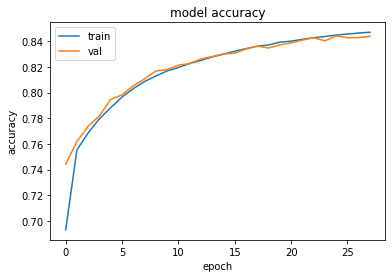

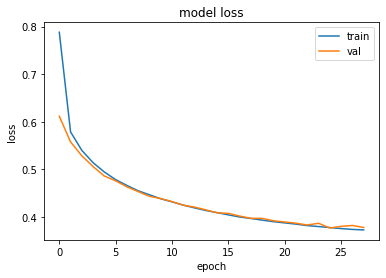

Test loss: 0.3792280852794647
Test accuracy: 0.843024730682373
                   precision    recall  f1-score   support

       Spruce/Fir       0.86      0.81      0.84     42368
   Lodgepole Pine       0.85      0.90      0.87     56661
   Ponderosa Pine       0.80      0.84      0.82      7151
Cottonwood/Willow       0.83      0.61      0.71       549
            Aspen       0.74      0.40      0.52      1899
      Douglas-fir       0.65      0.61      0.63      3473
        Krummholz       0.84      0.87      0.86      4102

         accuracy                           0.84    116203
        macro avg       0.80      0.72      0.75    116203
     weighted avg       0.84      0.84      0.84    116203



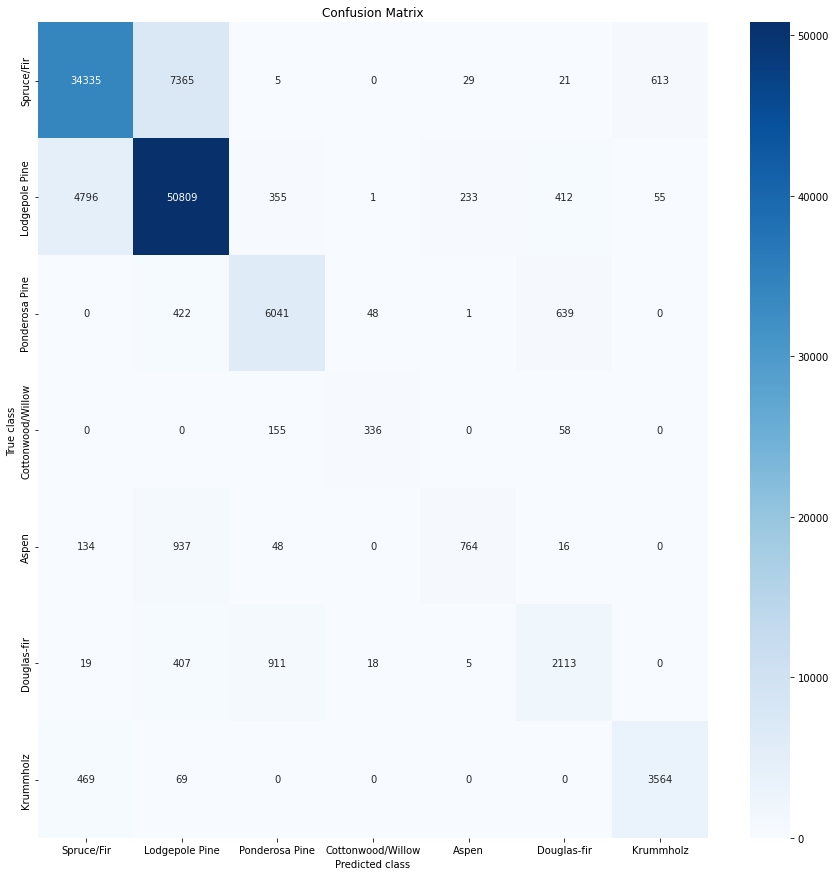

In [15]:
if __name__ == '__main__':
    main()

**Conclusions:**

The numbers along the diagonal of the heatmap show how many were correctly classified. All other numbers on either sides of the diagonal show mis-classifications. We see that Lodgepole Pine, Cottonwood Willow, Aspen, and Douglas-Fir suffer from a high percentage of mis-classifications. To investigate the possible causes, one can explore the following:

Check the proportion of observations for each cover-type. Imbalances in the dataset will affect classification.
How each wilderness area is distributed.
Find the similarties among different cover-types (correlation, scatter-plots, etc.) These similarities might be one of the reasons the model might be tripping-up. There are ways to address it - one of it is to carefully remove all of the collinear variables, leaving only one.
Remove noise, inconsistent data and errors in training data - this should be done carefully with domain experts.
Try to use some other performance metric other than 'accuracy'. It fails to be a reliable metric when data in imbalanced. That is why we have other metrics such as Precision/Recall, F1-score etc.
Try resampling the data (undersample or oversample appropriately or stratified). Downsampling could be done with thresholding.
The most important thing to understand here is that in deep-learning, the gradient(s) of the majority class(es) dominate(s) and will influence the weight-updates. There are also some advanced techniques that will ameliorate this situation.